In [14]:
import pandas as pd
import sys
import numpy as np

from kornmo import KornmoDataset
from geodata import get_farmer_elevation
import kornmo_utils as ku
from frostdataset import FrostDataset

%load_ext autoreload
%autoreload 2

TIMESTEPS = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def filter_by_years(years, data):
    return data[data['year'].isin(years)]


def get_interpolated_data(years, weather_feature):
    data = pd.DataFrame()

    print(f"Loading {weather_feature} data...")
    for year in years:
        tmp_df = pd.read_csv(f'../../kornmo-data-files/raw-data/weather-data/nn_interpolated/{weather_feature}/{weather_feature}_interpolated_{year}-03-01_to_{year}-10-01.csv')
        tmp_df.insert(0, 'year', year)
        data = pd.concat([data, tmp_df])

    # Drop columns containing 'Unnamed'
    data.drop(columns=[col for col in data.columns if 'Unnamed' in col], inplace=True)

    return_data = ku.normalize(data.filter(regex='day_.*'))
    return_data = return_data.rename(columns=lambda x: f"{weather_feature + x[4:]}")
    columns_to_add = ['orgnr', 'year', 'longitude', 'latitude', 'elevation']
    for i, col in enumerate(columns_to_add):
        return_data.insert(i, col, data[col])

    print(f"Number of loaded entries: {return_data.shape[0]}")
    return return_data

def get_proximity_data(years, weather_feature):
    data = pd.DataFrame()
    print(f"Loading {weather_feature} data...")
    for year in years:
        tmp_df = pd.read_csv(f'../../kornmo-data-files/raw-data/weather-data/by_proximity/{weather_feature}/{weather_feature}_by_proximity_{year}-03-01_to_{year}-10-01.csv')
        tmp_df.drop(columns=['ws_id'], inplace=True)
        tmp_df.insert(0, 'year', year)
        data = pd.concat([data, tmp_df])

    return_data = ku.normalize(data.filter(regex='day_.*'))
    return_data = return_data.rename(columns=lambda x: f"{weather_feature + x[4:]}")

    columns_to_add = ['orgnr', 'year']
    for i, col in enumerate(columns_to_add):
        return_data.insert(i, col, data[col])


    print(f"Number of loaded entries: {return_data.shape[0]}")
    return return_data

def get_soilquality_data():
    data = pd.read_csv(f'../../kornmo-data-files/raw-data/farm-information/farmers-with-coordinates-and-soil_quality.csv')
    data.drop(columns=['Unnamed: 0', 'latitude', 'longitude', 'elevation'], inplace=True)
    return_data = ku.normalize(data.drop(columns=['orgnr']))
    return_data.insert(0, 'orgnr', data['orgnr'])
    return return_data


def get_area_and_croptype():
    data = pd.read_csv('../../kornmo-data-files/raw-data/crop-classification-data/week_1_11/field_areas.csv')
    data.drop(columns=['Unnamed: 0'], inplace=True)
    data.drop(data[data['area'] < 1500].index, inplace = True)
    data["area"] = ku.normalize(data["area"])
    return data

## Load deliveries, weather, and historical data

In [8]:
years = [2017, 2018, 2019]

frost = FrostDataset()
kornmo = KornmoDataset()
deliveries = kornmo.get_deliveries().pipe(ku.split_farmers_on_type)

elevation_data = get_farmer_elevation()
deliveries = deliveries.merge(elevation_data, on=['orgnr'], how='left').fillna(0)

deliveries["yield"] = ku.normalize(deliveries["levert"]/deliveries["areal"], 0, 1000)
deliveries["areal"] = ku.normalize(deliveries["areal"])
deliveries['fulldyrket'] = ku.normalize(deliveries['fulldyrket'])
deliveries['overflatedyrket'] = ku.normalize(deliveries['overflatedyrket'])
deliveries['tilskudd_dyr'] = ku.normalize(deliveries['tilskudd_dyr'])
deliveries['lat'] = ku.normalize(deliveries['lat'])
deliveries['elevation'] = ku.normalize(deliveries['elevation'])

deliveries["key"] = deliveries.orgnr.astype(str) + "/" + deliveries.year.astype(str)
deliveries = deliveries.set_index("key")
deliveries = filter_by_years(years, deliveries)

deliveries
# test = deliveries.loc["869093262/2017"]
# test.loc[test['bygg'] == 2.0]

Loading deliveries...
Number of deliveries loaded: 88624


,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,areal,bygg,havre,hvete,rug_og_rughvete,lat,elevation,yield
key,,,,,,,,,,,,,,,,,,
811555762/2017,2017,811555762,1653,24,2,0,0.007241,0.0,0.000000,17067,0.017475,1.0,0.0,0.0,0.0,0.959116,0.051198,0.289271
811580082/2017,2017,811580082,1124,25,5,0,0.110575,0.0,0.335581,81204,0.064477,1.0,0.0,0.0,0.0,0.891830,0.024510,0.377693
811675792/2017,2017,811675792,709,2023,12,0,0.014180,0.0,0.000000,10902,0.020789,1.0,0.0,0.0,0.0,0.896483,0.014706,0.155743
811675792/2017,2017,811675792,709,2023,12,0,0.014180,0.0,0.000000,2335,0.004218,0.0,0.0,1.0,0.0,0.896483,0.014706,0.155667
811935662/2017,2017,811935662,125,207,1,0,0.014331,0.0,0.000000,33166,0.031636,0.0,0.0,1.0,0.0,0.907412,0.073529,0.312887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999659209/2019,2019,999659209,811,31,64,0,0.013728,0.0,0.000000,13426,0.018078,1.0,0.0,0.0,0.0,0.898225,0.068627,0.220098
999662730/2019,2019,999662730,715,247,1,0,0.043898,0.0,0.000000,86888,0.053028,0.0,1.0,0.0,0.0,0.902149,0.093137,0.490893
999662730/2019,2019,999662730,715,247,1,0,0.043898,0.0,0.000000,44841,0.035854,0.0,0.0,1.0,0.0,0.902149,0.093137,0.373675


In [9]:
historical = ku.get_historical_production(kornmo, [2017, 2018, 2019], 4)
historical = deliveries.merge(historical, how='left').fillna(0)
historical["key"] = historical.orgnr.astype(str) + "/" + historical.year.astype(str)
historical = historical.drop(columns=deliveries.columns)
historical = historical.drop_duplicates(subset='key')
historical = historical.set_index("key")
historical

Loading historical grants data...
Historical data loaded for years 2013 to 2020.


,bygg_sum_0,hvete_sum_0,havre_sum_0,rug_og_rughvete_sum_0,bygg_sum_1,hvete_sum_1,havre_sum_1,rug_og_rughvete_sum_1,bygg_sum_2,hvete_sum_2,havre_sum_2,rug_og_rughvete_sum_2,bygg_sum_3,hvete_sum_3,havre_sum_3,rug_og_rughvete_sum_3
key,,,,,,,,,,,,,,,,
811555762/2017,1.3687,0.0000,0.0000,0.0,2.2050,0.0000,0.0000,0.0,2.0620,0.0000,0.0000,0.0,2.2445,0.0000,0.0000,0.0
811580082/2017,2.9200,0.0000,0.0000,0.0,4.7596,0.0000,0.0000,0.0,6.4999,0.0000,0.0000,0.0,11.7227,0.0000,0.0000,0.0
811675792/2017,0.0000,0.0000,0.0000,0.0,0.0000,2.8870,0.6015,0.0,0.0000,1.4844,0.2770,0.0,0.0000,2.2717,0.4869,0.0
811935662/2017,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,1.0643,2.5620,0.0000,0.0
812075322/2017,1.7688,0.4413,0.0000,0.0,3.3676,0.0000,0.0000,0.0,1.7060,1.4768,0.0000,0.0,2.2838,1.0750,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999640001/2019,0.0000,21.5508,4.7821,0.0,14.6406,0.0000,4.8990,0.0,9.4914,33.1335,5.0059,0.0,8.4269,6.3109,0.0000,0.0
999659209/2019,0.0000,2.2603,0.0000,0.0,1.8102,0.0000,0.0000,0.0,0.0000,1.1576,0.0000,0.0,0.0000,0.0000,1.5396,0.0
999662730/2019,0.0000,5.1119,9.7433,0.0,0.0000,2.9122,10.4515,0.0,0.0000,4.7917,8.2873,0.0,0.0000,1.8919,5.8078,0.0


In [10]:
sunlight_data = get_interpolated_data(years, 'sunlight')
daydegree5_data = get_interpolated_data(years, 'daydegree5').drop(columns=['longitude', 'latitude', 'elevation'])
ground_data = get_proximity_data(years, 'ground')

temp_and_precip_data = frost.get_as_aggregated(1).dropna().astype(float)
weather_data = temp_and_precip_data.merge(sunlight_data, how='left', on=['orgnr', 'year'])
weather_data = weather_data.merge(daydegree5_data, how='left', on=['orgnr', 'year'])
weather_data = weather_data.merge(ground_data, how='left', on=['orgnr', 'year'])

print(f"Merged {temp_and_precip_data.shape[1]} features of temp and precip data, {sunlight_data.shape[1]} features of sunlight data, {daydegree5_data.shape[1]} features of daydegree data, {ground_data.shape[1]} features of ground data to a total of {weather_data.shape[1]} features")

#weather_data = frost.get_as_aggregated(1).dropna().astype(float)

weather_data["key"] = weather_data.orgnr.astype(int).astype(str) + "/" + weather_data.year.astype(int).astype(str)
weather_data = filter_by_years(years, weather_data)
weather_data.drop(columns=["year", "orgnr"], inplace=True)
weather_data = weather_data.drop_duplicates(subset=["key"])
weather_data = weather_data.set_index("key")

weather_data


Loading sunlight data...
Number of loaded entries: 30462
Loading daydegree5 data...
Number of loaded entries: 30462
Loading ground data...
Number of loaded entries: 30462
Loading weather data...
Weather data entries loaded: 33003
Merged 859 features of temp and precip data, 219 features of sunlight data, 216 features of daydegree data, 216 features of ground data to a total of 1504 features


,growth_start_day,min_temp0,min_temp1,min_temp2,min_temp3,min_temp4,min_temp5,min_temp6,min_temp7,min_temp8,...,ground204,ground205,ground206,ground207,ground208,ground209,ground210,ground211,ground212,ground213
key,,,,,,,,,,,,,,,,,,,,,
811555762/2017,0.061905,0.491667,0.411667,0.421667,0.496667,0.486667,0.448333,0.391667,0.361667,0.406667,...,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
811580082/2017,0.038095,0.505000,0.521667,0.560000,0.543333,0.526667,0.473333,0.413333,0.446667,0.560000,...,0.285714,0.00,0.125,0.111111,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222
811675792/2017,0.114286,0.485000,0.435000,0.503333,0.500000,0.450000,0.430000,0.390000,0.300000,0.490000,...,0.142857,0.25,0.125,0.111111,0.142857,0.142857,0.285714,0.111111,0.000000,0.111111
811935662/2017,0.114286,0.491667,0.465000,0.473333,0.466667,0.438333,0.406667,0.370000,0.411667,0.488333,...,0.142857,0.00,0.125,0.111111,0.285714,0.142857,0.142857,0.111111,0.000000,0.000000
812075322/2017,0.114286,0.458333,0.400000,0.440000,0.458333,0.430000,0.410000,0.398333,0.300000,0.440000,...,0.285714,0.50,0.125,0.222222,0.285714,0.285714,0.285714,0.222222,0.000000,0.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997229789/2019,0.219048,0.456667,0.445000,0.423333,0.341667,0.291667,0.281667,0.326667,0.396667,0.386667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997237269/2019,0.233333,0.418333,0.371667,0.486667,0.481667,0.415000,0.421667,0.453333,0.358333,0.320000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997365747/2019,0.219048,0.405000,0.401667,0.388333,0.216667,0.181667,0.143333,0.296667,0.383333,0.270000,...,0.285714,0.50,0.125,0.111111,0.142857,0.142857,0.142857,0.111111,0.111111,0.111111


In [11]:
soilquality_data = get_soilquality_data()
soilquality_data["key"] = soilquality_data.orgnr.astype(int).astype(str)
soilquality_data.drop(columns=["orgnr"], inplace=True)
soilquality_data = soilquality_data.drop_duplicates(subset=["key"])
soilquality_data = soilquality_data.set_index("key")
soilquality_data.dropna(inplace=True)
soilquality_data

,mean_soil_quality,soil_quality_1,soil_quality_2,soil_quality_3
key,,,,
969102404,0.096330,0.065414,0.012448,0.021277
983375782,0.416667,0.005567,0.026279,0.010638
969924358,0.239130,0.020181,0.016598,0.017730
869249572,0.127451,0.027836,0.012448,0.007092
887932522,0.239130,0.011134,0.004149,0.014184
...,...,...,...,...
869672092,0.369048,0.027836,0.035961,0.063830
995492008,0.194030,0.032707,0.019364,0.021277
914335027,0.152174,0.011830,0.006916,0.003546


In [12]:
area_data = get_area_and_croptype()
area_data["key"] = area_data.orgnr.astype(int).astype(str) + "/" + area_data.year.astype(int).astype(str)
print(len(set(area_data['orgnr'])))
area_data.drop(columns=["year", "orgnr"], inplace=True)
#area_data = area_data.drop_duplicates(subset=["key"])
area_data = area_data.set_index("key")
area_data

6872


,crop_type,area
key,,
811675792/2017,hvete,0.015621
812075322/2017,bygg,0.021547
812075322/2018,bygg,0.021547
812075322/2019,havre,0.021547
812686992/2017,hvete,0.059923
...,...,...
999666248/2017,havre,0.024795
999666248/2018,bygg,0.015315
999666248/2018,havre,0.009247


In [8]:
weather_data.loc["997690877/2019"].filter(regex='total_rain(([1-7]?[0-9])|(8[0-3]))$')

total_rain0     0.48
total_rain1     0.60
total_rain2     0.40
total_rain3    -0.00
total_rain4    -0.00
                ... 
total_rain79   -0.00
total_rain80    0.11
total_rain81   -0.00
total_rain82   -0.00
total_rain83    0.30
Name: 997690877/2019, Length: 84, dtype: float64

## Split training and validation data, and add data to the image iterators

In [15]:
import sys
from sentinel.storage import SentinelDataset
sat_img_path = 'E:/MasterThesisData/Satellite_Images'
sd = SentinelDataset("E:/MasterThesisData/Satellite_Images/combined_uncompressed.h5")
train, val = sd.to_iterator().split(rand_seed='abc')


def add_historical(orgnr, year, data):
    if f"{orgnr}/{year}" in historical.index.values:
        h_data = historical.loc[f"{orgnr}/{year}"]
        return {'historical': h_data.values }
    else:
        return []


def add_soilquality(orgnr, year, data):
    if str(orgnr) in soilquality_data.index.values:
        soil_data = soilquality_data.loc[orgnr]
        return {'soil_data': soil_data.values}
    else:
        return []


def add_weather(orgnr, year, data):
    if f"{orgnr}/{year}" not in weather_data.index:
        return []

    wd = weather_data.loc[f"{orgnr}/{year}"]

    min_temps = wd.filter(regex='min_temp(([1-7]?[0-9])|(8[0-3]))$').values
    mean_temps = wd.filter(regex='mean_temp(([1-7]?[0-9])|(8[0-3]))$').values
    max_temps = wd.filter(regex='max_temp(([1-7]?[0-9])|(8[0-3]))$').values
    total_rain = wd.filter(regex='total_rain(([1-7]?[0-9])|(8[0-3]))$').values

    sunlight = wd.filter(regex='sunlight(([1-7]?[0-9])|(8[0-3]))$').values
    daydegree5 = wd.filter(regex='daydegree5(([1-7]?[0-9])|(8[0-3]))$').values
    ground = wd.filter(regex='ground(([1-7]?[0-9])|(8[0-3]))$').values

    assert len(min_temps) == len(mean_temps) == len(max_temps) == len(total_rain) == len(sunlight) == len(daydegree5) == len(ground) == TIMESTEPS*7
    wd = np.concatenate((min_temps, mean_temps, max_temps, total_rain, sunlight, daydegree5, ground), axis=0)

    return { 'weather': wd }

def add_grain_types(orgnr, year, data):
    samples = deliveries.loc[[f"{orgnr}/{year}"]]
    if f"{orgnr}/{year}" in area_data.index.values:
        farm_area = area_data.loc[[f"{orgnr}/{year}"]]
        all_data = []

        for i, row in farm_area.iterrows():
            sample = {}
            if row['crop_type'] == 'bygg': sample["type"] = (1,0,0)
            elif row['crop_type'] == 'havre': sample["type"] = (0,1,0)
            elif row['crop_type'] == 'hvete': sample["type"] = (0,0,1)

            sample['area'] = row['area']

            if isinstance(samples, pd.DataFrame):

                del_sample = samples.loc[samples[row['crop_type']] == 1.0]
                if len(del_sample.index) > 0:
                    sample["lat"] = del_sample["lat"].values[0]
                    sample["elevation"] = del_sample["elevation"].values[0]
                    sample["yield"] = del_sample["yield"].values[0]
                    all_data.append(sample)

            else:
                del_sample = samples
                sample["lat"] = del_sample["lat"]
                sample["elevation"] = del_sample["elevation"]
                sample["yield"] = del_sample["yield"]
                all_data.append(sample)


        return all_data
    else:
        return []


# crop_type        bygg
# area         0.072578

train = train.with_data(add_historical, True)\
             .with_data(add_weather, True)\
             .with_data(add_grain_types, True)\
             .with_data(add_soilquality, True)

val = val.with_data(add_historical, True)\
         .with_data(add_weather, True)\
         .with_data(add_grain_types, True)\
         .with_data(add_soilquality, True)

100%|██████████| 3030/3030 [00:00<00:00, 5519.00it/s]


In [10]:
print(len(train))
for test_data in train:
    print(test_data)
    break



12085
('980491641', '2018', <sentinel.storage.SentinelImageSeriesSource object at 0x00000291B1845960>, {'historical': array([10.2727, 14.2386,  5.0245, 12.7975, 19.0491, 22.8257,  0.    ,
       13.6096, 13.054 , 14.2208,  0.    , 12.7855, 18.0631, 16.8538,
        0.    , 13.9449]), 'weather': array([ 0.12166667,  0.145     ,  0.315     ,  0.355     ,  0.37166667,
        0.38      ,  0.43333333,  0.445     ,  0.36166667,  0.34333333,
        0.37166667,  0.44      ,  0.41      ,  0.28166667,  0.36666667,
        0.28      ,  0.21333333,  0.22333333,  0.35833333,  0.45166667,
        0.46      ,  0.43833333,  0.47166667,  0.50666667,  0.465     ,
        0.37666667,  0.30666667,  0.26166667,  0.255     ,  0.26666667,
        0.29      ,  0.29      ,  0.29333333,  0.305     ,  0.48166667,
        0.50666667,  0.48333333,  0.46666667,  0.46333333,  0.51      ,
        0.48666667,  0.44333333,  0.405     ,  0.42333333,  0.48666667,
        0.49166667,  0.55333333,  0.55666667,  0.5583333

In [17]:
from tqdm import tqdm
from mask.mask_dataset_classification import MaskDatasetClassification
from mask.utils import add_mask_as_channel, apply_mask_to_image_series

mask_dataset_path = "../../kornmo-data-files/raw-data/crop-classification-data/week_1_11/week_1_11_masks.h5"


mask_dataset = MaskDatasetClassification(mask_dataset_path)
mask_iterator = mask_dataset.get_iterator()
mask_dict = {}

classes = ['bygg', 'havre', 'hvete']

for orgnr, year, crop_type, mask in tqdm(mask_iterator, total=mask_iterator.n):
    mask_dict[f'{orgnr}/{year}/{crop_type}'] = mask

def apply_mask(orgnr, year, imgs, data):
    crop_type = classes[data['type'].index(1)]

    mask = mask_dict[f"{orgnr}/{year}/{crop_type}"]
    return apply_mask_to_image_series(mask, imgs)

train = train.filter(lambda orgnr, year, _,data: f"{orgnr}/{year}/{classes[data['type'].index(1)]}" in mask_dict)
val = val.filter(lambda orgnr, year, _,data: f"{orgnr}/{year}/{classes[data['type'].index(1)]}" in mask_dict)

print(f"train samples: {len(train)}")
print(f"val samples: {len(val)}")

100%|██████████| 25280/25280 [01:53<00:00, 222.15it/s]


train samples: 12085
val samples: 3014


In [18]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow.data.experimental import assert_cardinality
from sentinel.transform import salt_n_pepper, rotate180, rotate90
import matplotlib.pyplot as plt
from src.utils import to_rgb

timesteps = 12

stride = 10
def top_left(imgs):
    return imgs[...,:-stride, :-stride,:]
def top_right(imgs):
    return imgs[...,:-stride, stride:,:]
def bot_left(imgs):
    return imgs[...,stride:, :-stride,:]
def bot_right(imgs):
    return imgs[...,stride:, stride:,:]
def center(imgs):
    s = stride//2
    return imgs[...,s:-s, s:-s,:]

def rotate_random(imgs):
    #angle = np.random.rand(timesteps) * 6.28
    angle = tf.constant(np.pi/8)
    return tfa.image.rotate(imgs, angle)

augmented_dataset = train\
    .transform(apply_mask)\
    .augment([center, top_left, top_right, bot_left, bot_right], keep_original=False)\
    .transform(salt_n_pepper())\
    .transform(rotate_random)


def apply_output(orgnr, year, img_source, data):
    features = data["area"], *data["type"], *data["soil_data"]
    output = data["yield"]
    weather = data["weather"]
    return {"cnn_input": img_source[0:timesteps], "feature_input": features, "weather_input": weather}, output


train_dataset = tf.data.Dataset.from_generator(
    augmented_dataset.apply(apply_output).shuffled(),
    output_types=({"cnn_input": tf.dtypes.float64, "feature_input": tf.dtypes.float64, "weather_input": tf.dtypes.float64}, tf.dtypes.float64),
).apply(assert_cardinality(len(augmented_dataset)))


val_dataset = tf.data.Dataset.from_generator(
    val.transform(apply_mask).transform(center).apply(apply_output),
    output_types=({"cnn_input": tf.dtypes.float64, "feature_input": tf.dtypes.float64, "weather_input": tf.dtypes.float64}, tf.dtypes.float64),
).apply(assert_cardinality(len(val)))

print(f"Training samples: {len(train)}")
print(f"Augmented samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 12085
Augmented samples: 60425
Validation samples: 3014


In [21]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow import keras


def CNN(input_dim, output_dim):
    input_layer = layers.Input(shape=input_dim)
    y = layers.Conv2D(16, (3, 3), activation=tf.nn.relu, padding='same')(input_layer)
    y = layers.MaxPool2D((2, 2))(y)
    y = layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')(y)
    y = layers.MaxPool2D((2, 2))(y)
    y = layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')(y)
    y = layers.MaxPool2D((2, 2))(y)
    y = layers.Flatten()(y)
    y = layers.Dense(output_dim, activation=tf.nn.relu)(y)

    return models.Model(inputs=[input_layer], outputs=[y], name="SingleImageCNN")

scnn = CNN((90, 90, 12), 64)
# scnn.summary(line_length=130)

input_weather = layers.Input(shape=timesteps*7*7, name="weather_input")
t_wm = layers.Reshape((7, timesteps*7))(input_weather)
t_wm = layers.Permute((2, 1))(t_wm)
t_wm = layers.Conv1D(64, 7, 7, activation=tf.nn.relu)(t_wm)

input_cnn = layers.Input(shape=(timesteps, 90, 90, 12), name="cnn_input")

feature_input = layers.Input(shape=(9,), name="feature_input")
feature_repeated = layers.RepeatVector(timesteps)(feature_input)

cnn = layers.TimeDistributed(scnn)(input_cnn)
cnn = layers.Concatenate(axis=2)([cnn, feature_repeated, t_wm])
cnn = layers.GRU(128)(cnn)
cnn = layers.Flatten()(cnn)
cnn = layers.Dense(128, activation=tf.nn.relu)(cnn)
cnn = layers.Dense(1)(cnn)

cnn = models.Model(inputs=[input_weather, input_cnn, feature_input], outputs=cnn, name="CNN")
# cnn.summary(line_length=130)

cnn.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')

model_checkpoint = keras.callbacks.ModelCheckpoint(
    './training',
    monitor="val_loss",
    verbose=0,
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), model_checkpoint]

cnn_history = cnn.fit(
    train_dataset.take(10000).batch(32).prefetch(2),
    validation_data=val_dataset.batch(32).prefetch(2),
    epochs=100,
    verbose=1,
    callbacks=callbacks
)

# model = load_model('./training/epoch_100.hdf5')
#
# cnn_history = model.fit(
#         train_dataset.take(10000).batch(32).prefetch(2),
#         validation_data=val_dataset.batch(32).prefetch(2),
#         epochs=100,
#         verbose=1,
#         callbacks=callbacks
# )

Epoch 1/100
  6/313 [..............................] - ETA: 8:31 - loss: 0.2685

KeyboardInterrupt: 

In [16]:
predictions = cnn.predict(val_dataset.batch(32).prefetch(2))
predictions = np.array(predictions).flatten()
facts = val.apply(lambda orgnr, year, img, data: data["yield"]).as_array()

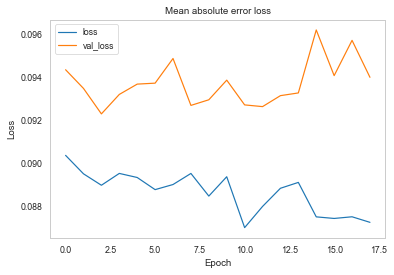

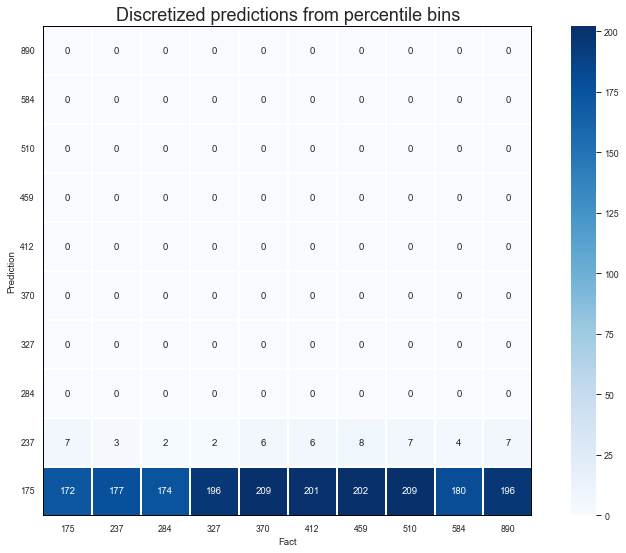

In [18]:
from src.kornmo.visualize import plot_history, plot_confusion_matrix

plot_history(cnn_history.history, save_file="logs/hybrid_end2end_mask_applied_0_11_history.svg")
plot_confusion_matrix(predictions*1000, facts*1000, n_bins=10, annot=True, save_file="logs/hybrid_end2end_mask_applied_0_11_cm.svg")

In [ ]:
pd.DataFrame(cnn_history.history).to_csv("logs/hybrid_end2end_mask_applied_0_11.csv")
cnn.save("logs/hybrid_end2end_mask_applied_0_11.keras")

In [19]:
mse = np.mean(np.abs(facts - predictions))
mse

0.31144730486158234

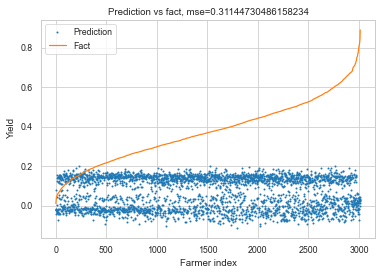

In [20]:
import matplotlib.pyplot as plt

df = pd.DataFrame(columns=["Prediction", "Fact"])
df.Fact = facts
df.Prediction = predictions

df = df.sort_values(by="Fact", ignore_index=True)

plt.plot(df["Prediction"].to_list(), 'o', markersize=1, label="Prediction")
plt.plot(df["Fact"].to_list(), label="Fact")
plt.ylabel('Yield')
plt.xlabel('Farmer index')
plt.title(f"Prediction vs fact, mse={mse}")
plt.legend()

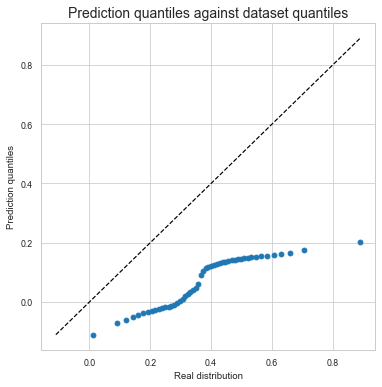

In [21]:
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

dist = df["Fact"]

a = df["Prediction"]
b = df["Fact"] # np.random.normal(dist.mean(), dist.std(), 1000000)

sns.set_style('whitegrid')
sns.set_context("paper")

plt.figure(figsize=(6,6))
plt.title("Prediction quantiles against dataset quantiles", fontdict={'fontsize': 14})

percentiles = np.linspace(0,100,50)
qn_a = np.percentile(a, percentiles)
qn_b = np.percentile(b, percentiles)

plt.plot(qn_b, qn_a, ls="", marker="o")

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
plt.plot(x,x, color="k", ls="--")

ax = plt.gca()
ax.set_ylabel("Prediction quantiles")
ax.set_xlabel("Real distribution")
plt.savefig("logs/hybrid_end2end_mask_applied_0_11_qqplot.svg")
plt.show()

In [ ]:
from sklearn.metrics import r2_score
r2_score(facts, predictions)